# 基于深度学习的Bitcoin价格预测（一），使用LSTM

### 【注】本文介绍
本系列文章将用于【学习输出笔记】，主题为：使用不同深度学习模型，对Bitcoin进行价格预测。文章内容包括：具体模型原理介绍，以及部分代码实践。
此文为第一篇，使用 Long short-Time Memory（LSTM）模型。

## 第一部分：原理介绍

### 一、LSTM，能解决什么问题？

1. 处理时间序列：能有效捕捉**时间**或顺序信息，能够记住长时间间隔内的信息。
2. 捕捉长期依赖关系：比RNN更能捕捉**长期**依赖关系。
3. 信息保持和更新机制：LSTM 使用了复杂的**门控机制**，可以动态地决定哪些信息应该被保留，哪些信息应该被遗忘，以及如何合并新的输入。

### 二、记忆细胞（核心）

![memoryCell](./memoryCell.jpg)

$$f_t = sigmoid(W_f*(h_tp,X_t)+b_f) \tag{1} $$
$$i_t = sigmoid(W_t*(h_tp,X_t)+b_c) \tag{2}$$
$$C_ht = tanh(W_C*(h_tp,X_t)+b_C) \tag{3}$$
长期记忆C_t:
$$C_t = C_tp*f_t + i_t*C_ht \tag{4}$$

输出h_t:
$$o_t = sigmoid(W_o*(h_tp,X_t)+b_f) \tag{4}$$
$$h_t = o_t*tanh(C_t)$$

### 三、LSTM的核心参数

![memoryCell](./params.jpg)

1. input_size:  输入数据的特征，在下文将看到feature_cols = ['Close', 'High', 'Low', 'Volume']，特征长度为4
2. num_layers:  隐藏层的数量。左图为1层，右图为3层。
3. hidden_size: 隐藏层神经元数量。上图中，都为5.

## 第二部分：代码实践
## 一、引入依赖，使用GPU（Mac）

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, recall_score, f1_score

# Check if there is a GPU available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Using device: mps


## 二、加载数据，定义模型

In [2]:
# Read data
data = pd.read_csv('BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Only the output of the last time step is taken
        return out

## 三、数据预处理，初始化模型

In [3]:
# Prepare data
feature_cols = ['Close', 'High', 'Low', 'Volume']
data = data.dropna() # Drop NaN rows
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[feature_cols])

# Segment the dataset
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [4]:
# Create sequence data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length, 0])  # Predicting next Close
    return np.array(sequences), np.array(labels)

seq_length = 13
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to Tensor and move to your device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1).to(device)

In [5]:
# Instantiate models, loss functions, and optimizers
input_size = len(feature_cols)
hidden_size = 256
num_layers = 3
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 四、训练模型，画出训练集和测试集损失-Loss图

Epoch [10/100], Train Loss: 0.019467, Test Loss: 0.042819
Epoch [20/100], Train Loss: 0.003739, Test Loss: 0.001510
Epoch [30/100], Train Loss: 0.001339, Test Loss: 0.001513
Epoch [40/100], Train Loss: 0.000650, Test Loss: 0.001752
Epoch [50/100], Train Loss: 0.000515, Test Loss: 0.002252
Epoch [60/100], Train Loss: 0.000485, Test Loss: 0.002153
Epoch [70/100], Train Loss: 0.000452, Test Loss: 0.001534
Epoch [80/100], Train Loss: 0.000435, Test Loss: 0.001306
Epoch [90/100], Train Loss: 0.000424, Test Loss: 0.001296
Epoch [100/100], Train Loss: 0.000411, Test Loss: 0.001309


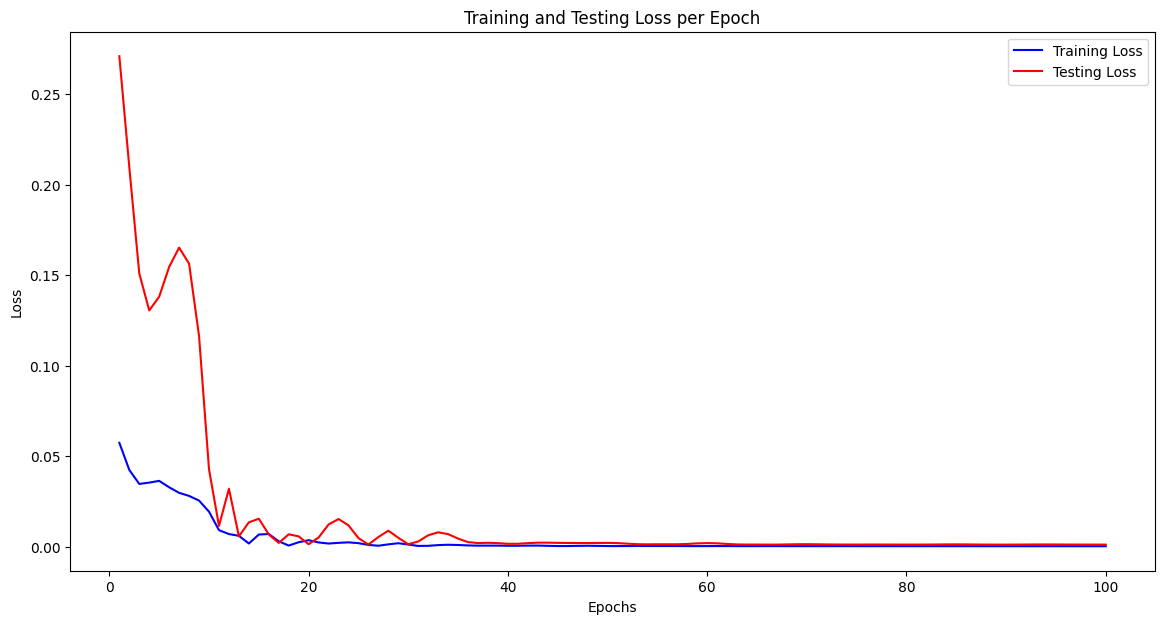

In [6]:
# Training model
num_epochs = 100
train_losses = []  # To store training losses
test_losses = []   # To store testing losses

for epoch in range(num_epochs):
    model.train()
    
    # Forward propagation
    outputs = model(X_train_tensor)  # No need to move to device again
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)  # Target data already on device
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())  # Save training loss
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())  # Save test loss

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')

# Plot training and testing loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', color='red')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 五、测试模型，并将预测值返归一化

In [7]:
# Testing model
model.eval()
with torch.no_grad():
    # Get predictions from the model on the test set
    test_outputs = model(X_test_tensor)

# Denormalize test outputs and actual values
test_outputs_np = test_outputs.cpu().numpy()  # Move output back to CPU for processing
y_test_np = y_test_tensor.cpu().numpy()

# Inverse transform to get original scale
predicted_price = scaler.inverse_transform(
    np.concatenate((test_outputs_np, np.zeros((test_outputs_np.shape[0], len(feature_cols)-1))), axis=1)
)[:, 0]  # Take only the 'Close' column

actual_price = scaler.inverse_transform(
    np.concatenate((y_test_np, np.zeros((y_test_np.shape[0], len(feature_cols)-1))), axis=1)
)[:, 0]  # Take only the 'Close' column


## 六、模型评价指标 MAE、RMSE、RMSSE、MASE

Normalized Mean Absolute Error（MAE）: 0.032317840693227934
Normalized Root Mean Squared Error（RMSE）: 0.04603038643986974
Relative Root Mean Squared Error (RMSSE): 0.1610
Mean Absolute Scaled Error (MASE): 0.1320


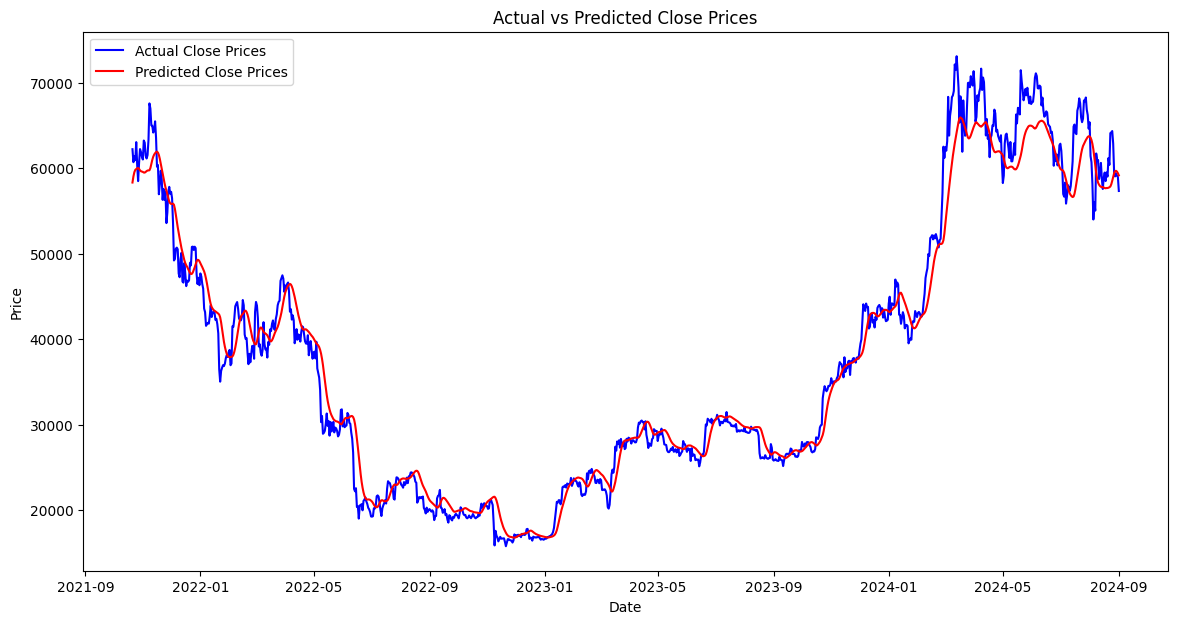

In [9]:
# 计算评价指标，并画出真实值和预测值的图像
mae = mean_absolute_error(actual_price, predicted_price)
rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))

# Normalizing MAE and RMSE
range_actual = np.max(actual_price) - np.min(actual_price)
mean_actual = np.mean(actual_price)

normalized_mae = mae / range_actual
normalized_rmse = rmse / range_actual

print(f'Normalized Mean Absolute Error（MAE）: {normalized_mae}')
print(f'Normalized Root Mean Squared Error（RMSE）: {normalized_rmse}')

# Calculate RMSSE
squared_errors = (actual_price - predicted_price) ** 2
rmsse = np.sqrt(np.mean(squared_errors)) / np.sqrt(np.mean((actual_price - mean_actual) ** 2))

# Calculate MASE
absolute_errors = np.abs(actual_price - predicted_price)
mase = np.mean(absolute_errors) / np.mean(np.abs(actual_price - mean_actual))

print(f'Relative Root Mean Squared Error (RMSSE): {rmsse:.4f}')
print(f'Mean Absolute Scaled Error (MASE): {mase:.4f}')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(actual_price):], actual_price, label='Actual Close Prices', color='blue')
plt.plot(data.index[-len(predicted_price):], predicted_price, label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# 假设我们需要将价格预测转化为二元分类问题，例如：
# 如果 predicted_price > 某个阈值，则标记为 1 (正类)，否则标记为 0 (负类)
threshold = actual_price.mean()  # 可以选择其他合适的阈值
predicted_labels = (predicted_price > threshold).astype(int)
actual_labels = (actual_price > threshold).astype(int)

# 计算准确率、召回率和 F1 分数
accuracy = accuracy_score(actual_labels, predicted_labels)
recall = recall_score(actual_labels, predicted_labels)
f1 = f1_score(actual_labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9771
Recall: 0.9913
F1 Score: 0.9745


## 有待解决的问题
1. 数据处理方面，可采用降噪处理，以提升模型的稳定性。
2. LSTM的记忆细胞只能存储单个数据，是否能扩展成矩阵？
3. 记忆细胞内的计算能否由顺序计算，提升为并行计算。

下一篇文章，将介绍一种模型：xLSTM，一定程度上能解决上述问题。